# Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import random as rd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.layers import Dense, Dropout, LSTM, BatchNormalization, Activation, Conv1D, TimeDistributed, Flatten, MaxPooling1D, Input, Conv1DTranspose, Concatenate
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop

# Import training and validation data

The training and validation data are imported from the CSV. It is therefore composed of 150 frames on which there are the 34 coordinates of the 17 keypoints for each videos. So, the dataset shape is: (number of video, 150, 34).
<br>
The data is also one hot encoded, to be used in the network. And the class distribution is checked to be sure that it is balanced.

In [2]:
names = os.listdir('./CSV_thunder/')
rd.shuffle(names)
split_ratio = 0.8
x_dataset = np.zeros((len(names), 150, 34))
y_dataset = [i.split('_')[0] for i in names]

for ind,file in enumerate(names):
    df = pd.read_csv('./CSV_thunder/'+file, index_col = 0)
    df.drop('Frame_number', inplace = True)
    dfT =df.transpose()
    x_dataset[ind,:,:] = dfT.to_numpy()
    print(ind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
#One hot encoding of label
classes = list(np.unique(y_dataset))
y_dataset_np = []
for classe in y_dataset:
    encoder = [0 for i in range(13)]
    ind = classes.index(classe)
    encoder[ind] = 1
    y_dataset_np.append(encoder)
y_dataset_np = np.array(y_dataset_np)

In [4]:
#Splitting the data with a well balance
X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset_np, train_size = split_ratio, random_state = 20, stratify=y_dataset_np)

Number of classes: 13


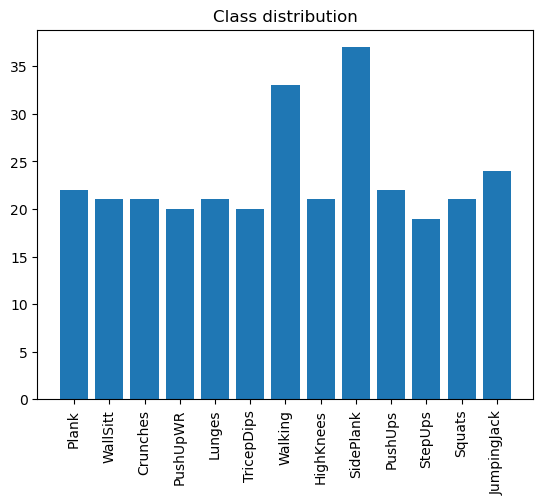

Number of classes: 13


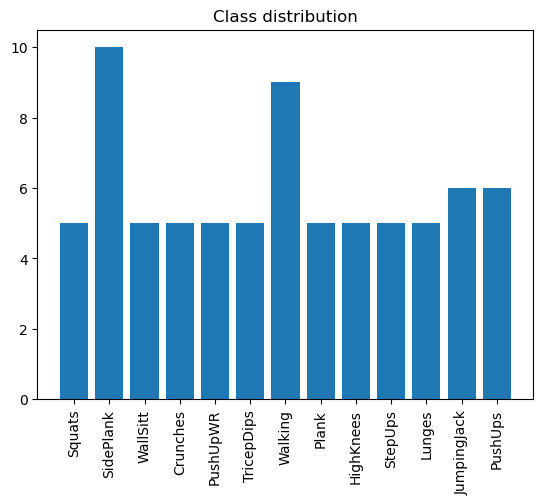

In [5]:
#Checking the class distribution in the training and validation set
activities = {}
for ind, activity_he in enumerate(list(y_train)):
    a = activity_he.tolist().index(1)
    activity = classes[a]
    if activity in activities.keys():
        activities[activity] = activities[activity] + 1 
    else:
        activities[activity] = 1

activities_2 = {}
for ind, activity_he in enumerate(list(y_test)):
    a = activity_he.tolist().index(1)
    activity = classes[a]
    if activity in activities_2.keys():
        activities_2[activity] = activities_2[activity] + 1 
    else:
        activities_2[activity] = 1

#Display class distribution
print("Number of classes: " + str(len(activities.keys())))
names = list(activities.keys())
values = list(activities.values())
plt.figure(1)
plt.bar(range(len(activities)), values, tick_label = names)
plt.title('Class distribution')
plt.xticks(rotation = 'vertical')
plt.show()

#Display class distribution
print("Number of classes: " + str(len(activities_2.keys())))
names = list(activities_2.keys())
values = list(activities_2.values())
plt.figure(2)
plt.bar(range(len(activities_2)), values, tick_label = names)
plt.title('Class distribution')
plt.xticks(rotation = 'vertical')
plt.show()


### Note
The first bar chart represents the class distribution in the training dataset and the second in the validation.

# Network

A combination of a 1D convolutional neural network and a LSTM is used to do the classification of the activity based on the coordinates of the joints.

In [6]:
#Define the parameters
n_timestep = X_train.shape[1]  #number of frames in one video
n_features = X_train.shape[2] #number of keypoint coordinate
n_outputs = len(classes) #number of classes

In [7]:
#Define the Network
def ConvNetwork(n_timestep, n_outputs):
    
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation ='relu', input_shape=(n_timestep,n_features)))
    model.add(Conv1D(32, kernel_size=3, activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size =2))
    
    model.add(Conv1D(64, kernel_size=3, activation ='relu'))
    model.add(Conv1D(64, kernel_size=3, activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size =2))
    
    model.add(Conv1D(128, kernel_size=3, activation ='relu'))
    model.add(Conv1D(128, kernel_size=3, activation ='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size =2))
    
    model.add(LSTM(256, return_sequences = True, recurrent_dropout = 0.2))
    model.add(LSTM(128, recurrent_dropout = 0.1))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    
    return model

In [8]:
#Building and summarizing of the network
n_outputs = 13
model = ConvNetwork(n_timestep, n_outputs)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 148, 32)           3296      
                                                                 
 conv1d_1 (Conv1D)           (None, 146, 32)           3104      
                                                                 
 batch_normalization (BatchN  (None, 146, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 73, 32)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 71, 64)            6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 69, 64)            1

In [9]:
#Compiling of the network
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss = 'categorical_crossentropy',
              metrics ='accuracy')

In [10]:
#Fitting of the network and saving the best model
checkpoint_filepath = './checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True)


mymodel_hist = model.fit(X_train, y_train, batch_size = 8, epochs = 250, verbose=1, validation_data = (X_test, y_test), callbacks = [model_checkpoint_callback])

Epoch 1/250
38/38 [==============================] - 16s 180ms/step - loss: 2.5461 - accuracy: 0.1192 - val_loss: 2.5584 - val_accuracy: 0.1053
Epoch 2/250
38/38 [==============================] - 6s 155ms/step - loss: 2.4466 - accuracy: 0.2053 - val_loss: 2.5507 - val_accuracy: 0.1184
Epoch 3/250
38/38 [==============================] - 5s 143ms/step - loss: 2.3639 - accuracy: 0.2848 - val_loss: 2.5427 - val_accuracy: 0.1711
Epoch 4/250
38/38 [==============================] - 6s 149ms/step - loss: 2.2997 - accuracy: 0.2980 - val_loss: 2.5304 - val_accuracy: 0.1711
Epoch 5/250
38/38 [==============================] - 5s 139ms/step - loss: 2.2077 - accuracy: 0.3311 - val_loss: 2.5183 - val_accuracy: 0.1447
Epoch 6/250
38/38 [==============================] - 6s 149ms/step - loss: 2.1354 - accuracy: 0.3477 - val_loss: 2.4986 - val_accuracy: 0.1579
Epoch 7/250
38/38 [==============================] - 6s 146ms/step - loss: 2.0649 - accuracy: 0.4073 - val_loss: 2.4685 - val_accuracy: 0.210

Epoch 58/250
38/38 [==============================] - 5s 130ms/step - loss: 0.2015 - accuracy: 0.9503 - val_loss: 0.7427 - val_accuracy: 0.7895
Epoch 59/250
38/38 [==============================] - 5s 130ms/step - loss: 0.2887 - accuracy: 0.9172 - val_loss: 0.8182 - val_accuracy: 0.8158
Epoch 60/250
38/38 [==============================] - 5s 127ms/step - loss: 0.2116 - accuracy: 0.9437 - val_loss: 0.6443 - val_accuracy: 0.8289
Epoch 61/250
38/38 [==============================] - 5s 139ms/step - loss: 0.2544 - accuracy: 0.9172 - val_loss: 0.7524 - val_accuracy: 0.7895
Epoch 62/250
38/38 [==============================] - 5s 134ms/step - loss: 0.2182 - accuracy: 0.9404 - val_loss: 0.5577 - val_accuracy: 0.8553
Epoch 63/250
38/38 [==============================] - 5s 131ms/step - loss: 0.2280 - accuracy: 0.9305 - val_loss: 0.5846 - val_accuracy: 0.8158
Epoch 64/250
38/38 [==============================] - 5s 142ms/step - loss: 0.2057 - accuracy: 0.9437 - val_loss: 0.5268 - val_accuracy:

Epoch 115/250
38/38 [==============================] - 5s 131ms/step - loss: 0.0495 - accuracy: 0.9801 - val_loss: 0.6637 - val_accuracy: 0.8289
Epoch 116/250
38/38 [==============================] - 5s 127ms/step - loss: 0.0789 - accuracy: 0.9868 - val_loss: 0.6687 - val_accuracy: 0.8158
Epoch 117/250
38/38 [==============================] - 5s 128ms/step - loss: 0.1511 - accuracy: 0.9735 - val_loss: 0.6448 - val_accuracy: 0.8684
Epoch 118/250
38/38 [==============================] - 5s 138ms/step - loss: 0.1038 - accuracy: 0.9735 - val_loss: 0.6875 - val_accuracy: 0.8026
Epoch 119/250
38/38 [==============================] - 5s 129ms/step - loss: 0.1393 - accuracy: 0.9570 - val_loss: 0.6338 - val_accuracy: 0.7763
Epoch 120/250
38/38 [==============================] - 5s 130ms/step - loss: 0.1238 - accuracy: 0.9603 - val_loss: 0.7142 - val_accuracy: 0.8026
Epoch 121/250
38/38 [==============================] - 5s 129ms/step - loss: 0.0793 - accuracy: 0.9735 - val_loss: 0.8196 - val_ac

38/38 [==============================] - 5s 127ms/step - loss: 0.0175 - accuracy: 0.9967 - val_loss: 0.5914 - val_accuracy: 0.8553
Epoch 228/250
38/38 [==============================] - 5s 128ms/step - loss: 0.0282 - accuracy: 0.9901 - val_loss: 0.6661 - val_accuracy: 0.8289
Epoch 229/250
38/38 [==============================] - 5s 127ms/step - loss: 0.0542 - accuracy: 0.9801 - val_loss: 0.5843 - val_accuracy: 0.8816
Epoch 230/250
38/38 [==============================] - 5s 130ms/step - loss: 0.0583 - accuracy: 0.9868 - val_loss: 0.6749 - val_accuracy: 0.8553
Epoch 231/250
38/38 [==============================] - 5s 143ms/step - loss: 0.0246 - accuracy: 0.9934 - val_loss: 0.7226 - val_accuracy: 0.8684
Epoch 232/250
38/38 [==============================] - 5s 140ms/step - loss: 0.0675 - accuracy: 0.9834 - val_loss: 0.6518 - val_accuracy: 0.8553
Epoch 233/250
38/38 [==============================] - 5s 123ms/step - loss: 0.0841 - accuracy: 0.9735 - val_loss: 0.5560 - val_accuracy: 0.8684

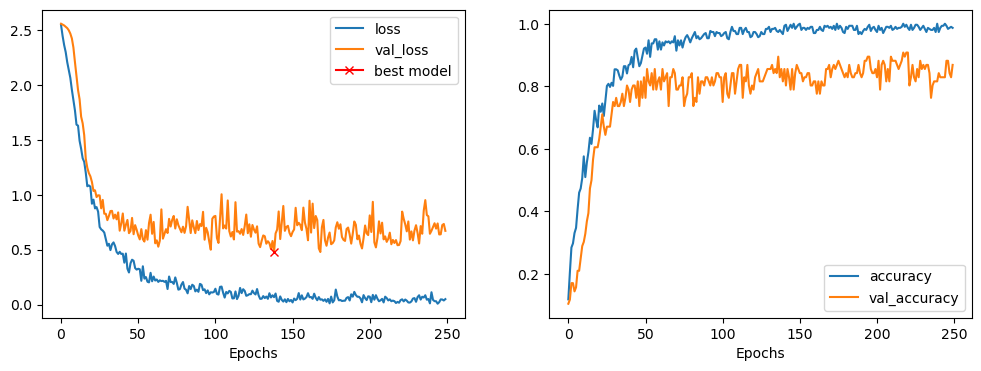

In [11]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].plot(mymodel_hist.history["loss"], label="loss")
axes[0].plot(mymodel_hist.history["val_loss"], label="val_loss")
axes[0].plot(np.argmin(mymodel_hist.history["val_loss"]),
             np.min(mymodel_hist.history["val_loss"]),
             marker="x", color="r", label="best model")
axes[0].legend();

axes[1].plot(mymodel_hist.history["accuracy"], label="accuracy")
axes[1].plot(mymodel_hist.history["val_accuracy"], label="val_accuracy")
axes[1].legend();


plt.setp(axes[:], xlabel = "Epochs")
plt.show()

### Results
The training set is almost fit perfectly and the performance reaches a reasonable level in the validation set with a best accuracy higher 90%. A small overfitting needs to be noticed.

In [14]:
#Loading the best model and using it to predict the classes of the validation dataset
model.load_weights(checkpoint_filepath)
y_pred = model.predict(X_test)

3/3 [==============================] - 1s 32ms/step


In [15]:
#Transform the probability vector that is the ouput of the prediction into a one hot encoded vector
y_pred_ =[]
y_test_ = []
for ind, prediction in enumerate(list(y_pred)):
    m = np.max(prediction)
    y_pred_.append(prediction.tolist().index(m))
    y_test_.append(y_test[ind].tolist().index(1))

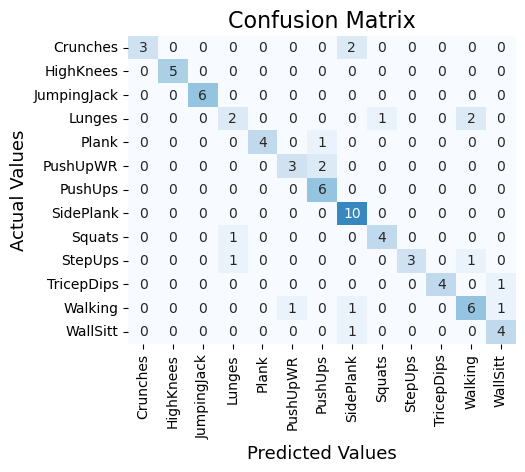

In [16]:
from sklearn.metrics import confusion_matrix 
import seaborn as sns

#Confusion matrix
cm = confusion_matrix(y_test_, y_pred_)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cbar = False, cmap = 'Blues', vmin = 0, vmax = 15)
plt.title('Confusion Matrix', size = 16)
plt.ylabel('Actual Values', size = 13)
plt.xlabel('Predicted Values', size = 13)
plt.show()

### Results
We can se that the result are really good. There is still some mistakes but some activities are perfectly identified as HighKnees, JumpingJacks, SidePlank or PushUp. This is good given the fact that the amount of data in each activity in the training dataset is really low. 

# Test

In this part the model is tested on an unseen dataset. This dataset is composed of the activity made in the unlabelled videos from the raw dataset (from video 30 to 60). Those videos have therefore been labelled manually.

In [17]:
#Load the new dataset
names_test = os.listdir('./CSV2_thunder/')
rd.shuffle(names_test)
x_testing_set = np.zeros((len(names_test), 150, 34))
y_testing_set = [i.split('_')[0] for i in names_test]

for ind,file in enumerate(names_test):
    df = pd.read_csv('./CSV2_thunder/'+file, index_col = 0)
    df.drop('Frame_number', inplace = True)
    dfT =df.transpose()
    x_testing_set[ind,:,:] = dfT.to_numpy()
    print(ind)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [18]:
#Predict the output in the test dataset
y_prediction_testing = model.predict(x_testing_set)

10/10 [==============================] - 0s 38ms/step


In [19]:
#Transform the probability prediction into a one hot encoded vector
y_pred_test =[]
y_true_test =[]
for ind, prediction in enumerate(list(y_prediction_testing)):
    m = np.max(prediction)
    y_pred_test.append(prediction.tolist().index(m))

for classe in y_testing_set:
    # needed because a mistake is present in the labelling of the test data 
    if classe == 'TricepsDips':
        classe = 'TricepDips'
    ind = classes.index(classe)
    y_true_test.append(ind)

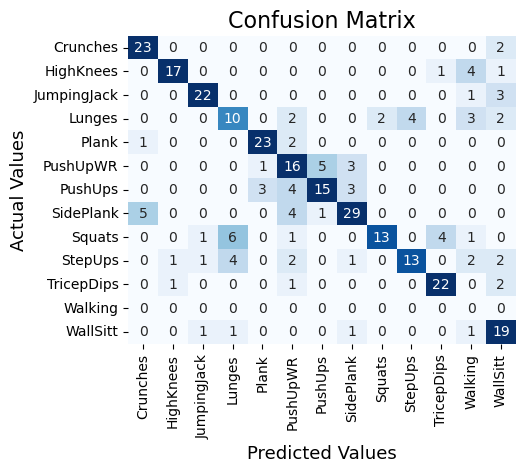

In [20]:
#Confusion matrix in the test dataset
cm = confusion_matrix(y_true_test, y_pred_test)
cm_df = pd.DataFrame(cm,
                     index = classes, 
                     columns = classes)

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt="d", cbar = False, cmap = 'Blues', vmin = 0, vmax = 15)
plt.title('Confusion Matrix', size = 16)
plt.ylabel('Actual Values', size = 13)
plt.xlabel('Predicted Values', size = 13)
plt.show()

### Results
The results are quite good. It is mainly well predicted which is really good as the test dataset has a poor quality. We can see a bit if a mixing in the PushUps, PushUpWR and SidePlank.